In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import time 
import seaborn as sns 
from matplotlib.ticker import PercentFormatter
import calendar
import matplotlib.ticker as ticker
from PIL import * 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import mannwhitneyu

In [2]:
jtwc_dat = pd.read_csv("jtwc_data19512021.csv")
jtwc_dat.shape

(168526, 26)

In [3]:
jtwc_dat.SID.nunique()

2686

In [4]:
index = jtwc_dat[jtwc_dat["USA_SSHS"] >= -3].index #-1 #-3
jtwc_dat = jtwc_dat.loc[index]
jtwc_dat.shape

(166955, 26)

In [5]:
#remove data points that are extratropical
jtwc_dat = jtwc_dat.dropna(subset = ["USA_WIND"])

indnET = jtwc_dat[jtwc_dat["NATURE"] != "ET"].index
jtwc_dat = jtwc_dat.loc[indnET]

In [6]:
jtwc_dat["ISO_TIME"] = pd.to_datetime(jtwc_dat["ISO_TIME"])
jtwc_dat["date_diff"] = jtwc_dat.groupby("SID")["ISO_TIME"].diff()
jtwc_dat["diff_sec"] = jtwc_dat["date_diff"]/np.timedelta64(1,"s") #to convert to seconds
jtwc_dat['time'] = jtwc_dat["ISO_TIME"].dt.time


In [7]:
ind_6h = jtwc_dat[(jtwc_dat["time"] == dt.time(0,0,0)) | (jtwc_dat["time"] == dt.time(6,0,0))
                | (jtwc_dat["time"] == dt.time(12,0,0)) | (jtwc_dat["time"] == dt.time(18,0,0)) ].index
jtwc_data = jtwc_dat.loc[ind_6h]

In [8]:
jtwc_data['Month'] = jtwc_data["ISO_TIME"].dt.month
jtwc_data['month'] = jtwc_data["Month"].apply(lambda x: calendar.month_abbr[x])

jtwc_data["diff_24h"] = -jtwc_data.groupby("SID")["USA_WIND"].diff(-4)
jtwc_data["diff_18h"] = -jtwc_data.groupby("SID")["USA_WIND"].diff(-3)
jtwc_data["diff_12h"] = -jtwc_data.groupby("SID")["USA_WIND"].diff(-2)
jtwc_data["diff_6h"] = -jtwc_data.groupby("SID")["USA_WIND"].diff(-1)

jtwc_data["wind_24"] = jtwc_data.groupby("SID")["USA_WIND"].shift(-4)
jtwc_data["wind_18"] = jtwc_data.groupby("SID")["USA_WIND"].shift(-3)
jtwc_data["wind_12"] = jtwc_data.groupby("SID")["USA_WIND"].shift(-2)
jtwc_data["wind_6"] = jtwc_data.groupby("SID")["USA_WIND"].shift(-1)

jtwc_data["d1"] = jtwc_data["wind_6"] - jtwc_data["USA_WIND"]
jtwc_data["d2"] = jtwc_data["wind_12"] - jtwc_data["wind_6"]
jtwc_data["d3"] = jtwc_data["wind_18"] - jtwc_data["wind_12"]
jtwc_data["d4"] = jtwc_data["wind_24"] - jtwc_data["wind_18"]

jtwc_data["dist_24h"] = jtwc_data.groupby("SID")["DIST2LAND"].shift(-4)
jtwc_data["dist_18h"] = jtwc_data.groupby("SID")["DIST2LAND"].shift(-3)
jtwc_data["dist_12h"] = jtwc_data.groupby("SID")["DIST2LAND"].shift(-2)
jtwc_data["dist_6h"] = jtwc_data.groupby("SID")["DIST2LAND"].shift(-1)

In [9]:
jtwc_data = jtwc_data[jtwc_data["SEASON"] <= 2020]

In [10]:
jtwc_data.SID.nunique()

2046

In [11]:
jtwc_data.tail()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,wind_12,wind_6,d1,d2,d3,d4,dist_24h,dist_18h,dist_12h,dist_6h
167281,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 12:00:00,TS,8.15000,101.750,...,20.0,25.0,-5.0,-5.0,0.0,-5.0,176.0,77.0,47.0,74.0
167283,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 18:00:00,TS,8.65714,100.771,...,20.0,20.0,-5.0,0.0,-5.0,NaN,NaN,176.0,77.0,47.0
167285,2020353N06129,2020,113,NI,BB,KROVANH,2020-12-25 00:00:00,TS,9.74000,99.600,...,15.0,20.0,0.0,-5.0,NaN,NaN,NaN,NaN,176.0,77.0
167287,2020353N06129,2020,113,NI,BB,KROVANH,2020-12-25 06:00:00,NR,10.10000,97.800,...,NaN,15.0,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,176.0
167289,2020353N06129,2020,113,NI,BB,KROVANH,2020-12-25 12:00:00,NR,11.30000,97.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Percentile

In [12]:
def myround(x, base = 5):
    return base*round(x/base)

In [13]:
perc = jtwc_data[(jtwc_data["DIST2LAND"] > 100) & (jtwc_data["dist_24h"] > 100) &
                  (jtwc_data["dist_18h"] > 100) &  (jtwc_data["dist_12h"] > 100)
                  &  (jtwc_data["dist_6h"] > 100) &  (jtwc_data["diff_24h"] < 0)]
perc = perc.sort_values(by = "diff_24h", ascending = True)
perc["round5_24h"] = perc["diff_24h"].apply(myround)
perc["mag_24hw"] = perc["round5_24h"].apply(np.abs)
r05 = perc.mag_24hw.replace(0,5)
perc.update(r05)

remove90 = perc[perc["mag_24hw"] <= 65].index
perc1 = perc.loc[remove90]

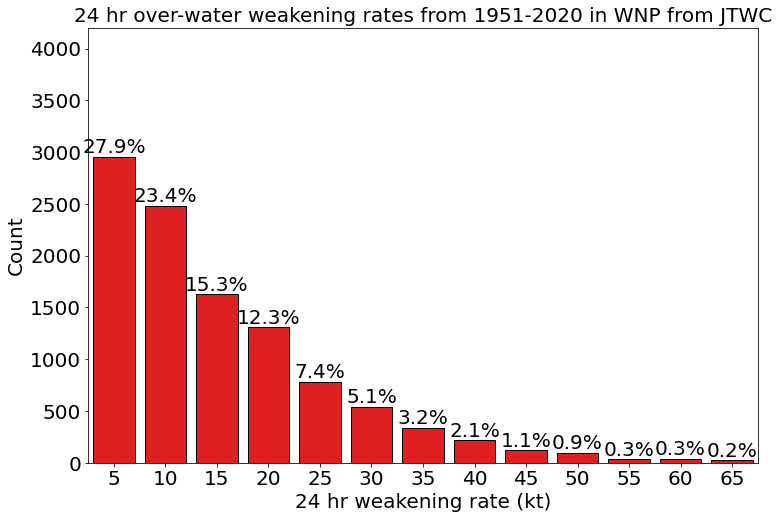

In [14]:
ncount = len(perc)
plt.figure(figsize = (12,8))
ax = sns.countplot(x="mag_24hw",data = perc1, color ="red", edgecolor = "black")
plt.xlabel("24 hr weakening rate (kt)", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', fontsize = 20) # set the alignment of the text

ax.set_ylim(0,1050)
plt.title("24 hr over-water weakening rates from 1951-2020 in WNP from JTWC", fontsize = 20)
plt.ylim(0, 4200)
plt.show()

In [15]:
jtwc_data.shape

(60059, 47)

In [16]:
perc.shape

(10606, 49)

### Rapid Weakening

In [17]:
threshold = jtwc_data[(jtwc_data["DIST2LAND"] > 100) & (jtwc_data["dist_24h"] > 100) &  (jtwc_data["dist_18h"] > 100) & 
                   (jtwc_data["dist_12h"] > 100) & (jtwc_data["dist_6h"] > 100) & (jtwc_data["diff_24h"] <= -25)
                    & (jtwc_data["diff_18h"] <=0) & (jtwc_data["diff_12h"] <= 0) & (jtwc_data["diff_6h"] <=0)
                     & (jtwc_data["d1"] <=0) & (jtwc_data["d2"] <=0) & (jtwc_data["d3"] <=0) & (jtwc_data["d4"] <=0)].index

In [18]:
jtwc_data.SID.nunique()

2046

In [19]:
jtwcdata = jtwc_data.loc[threshold]
jtwcdata.SID.nunique()

563

In [20]:
jtwcdata["date_diff_rw"] = jtwcdata.groupby("SID")["ISO_TIME"].diff()
jtwcdata["diff_sec_rw"] = jtwcdata["date_diff_rw"]/np.timedelta64(1,"s") #to convert to seconds

uniq_ind = jtwcdata[(jtwcdata["diff_sec_rw"] > 86400) | (jtwcdata["diff_sec_rw"].isna()) ].index
jtwc_filtered = jtwcdata.loc[uniq_ind]

In [21]:
jtwc_filtered.SID.nunique()

563

In [22]:
#get the SID of RW TCs 
RW_TC = jtwcdata["SID"].unique().tolist()
jtwc_data1 = jtwc_data[jtwc_data["SID"].isin(RW_TC)] #TC data of all RW TCs
jtwc_data1.shape

(21761, 47)

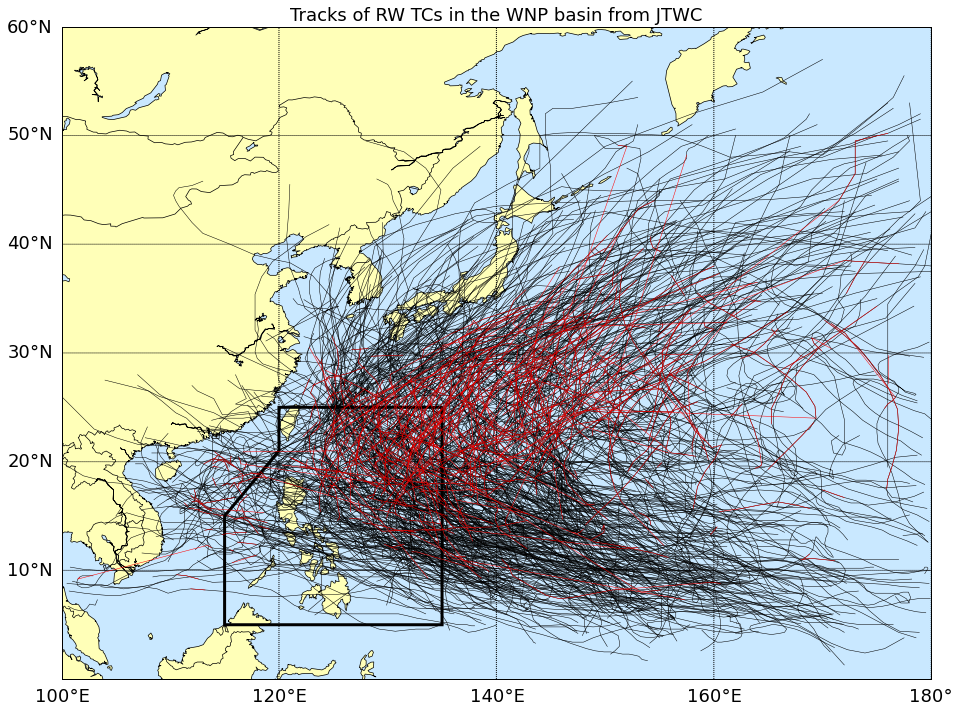

In [23]:
lon_ind = jtwc_data1[(jtwc_data1["USA_LON"] >= 100) & (jtwc_data1["USA_LON"] <= 180)].index
jtwc_lon = jtwc_data1.loc[lon_ind]

lon_jtwcdata = jtwcdata[(jtwcdata["USA_LON"] >= 100) & (jtwcdata["USA_LON"] <= 180)].index
jtwcdata_lon = jtwcdata.loc[lon_jtwcdata]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=60, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 18)
m.drawmeridians(np.arange(-180,180,20),labels=[0,0,0,1], fontsize = 18)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in jtwc_lon.groupby("SID"):
    lat = group.USA_LAT.values 
    lon = group.USA_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.5)

for name1, group1 in jtwcdata_lon.groupby("SID"):
    lat = group1.USA_LAT.values 
    lon = group1.USA_LON.values
    x1,y1 = m(lon, lat)
    plt.plot(x1,y1, 'r-', linewidth = 0.5)

plt.title("Tracks of RW TCs in the WNP basin from JTWC", fontsize = 18)
plt.show()

In [24]:
cmap1 = LinearSegmentedColormap.from_list("wgyr", ["w", "g", "y", "r"], N = 256)

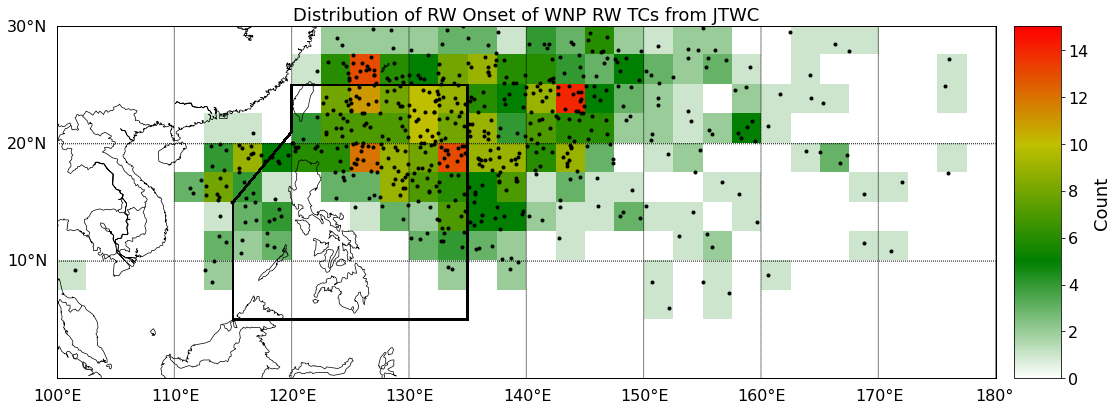

In [25]:
# has a 2.5 x 2.5 degree resolution 
plt.figure(figsize = (18, 12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary()
#m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
#m.fillcontinents()
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')

m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)


x_par = [115, 115, 120, 120, 125, 135,135, 115]
y_par =[5, 15, 21, 25, 25, 25, 5, 5]



Lon = jtwc_filtered.USA_LON.values
Lat = jtwc_filtered.USA_LAT.values 
nx, ny = 32, 12
lon_bins = np.linspace(100,180,nx+1)
lat_bins = np.linspace(0,30,ny+1)
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

a = m.imshow(density.T, interpolation='none', vmin=0, vmax=15, alpha=1, cmap=cmap1, zorder=1)
cbar = m.colorbar(a,'right')
cbar.set_label(label = "Count", size = 18)
cb = plt.cm.ScalarMappable()
cb.set_clim(0,25)
cbar.ax.tick_params(labelsize = 16) 



for lons, lats in zip(Lon, Lat):
    x, y = m.projtran(lons,lats)
    m.plot(x,y, color = "k", marker = "o", markersize = 3) #bd3020
    m.plot(x_par, y_par, "k-")

plt.title("Distribution of RW Onset of WNP RW TCs from JTWC", fontsize = 18)
plt.show()

In [26]:
jtwc_filtered.shape

(649, 49)

In [27]:
# for all PH landfalling TCs (RW and non-RW)
landfall_tc = jtwc_data[(jtwc_data["DIST2LAND"] >=0) &(jtwc_data["DIST2LAND"] <= 25.4) & (jtwc_data["USA_LON"] < 130) & (jtwc_data["USA_LON"] > 115) & (jtwc_data["USA_LAT"]>5) & (jtwc_data["USA_LAT"] <=21)].index
landfall_tcs = jtwc_data.loc[landfall_tc]
landfall_tcs.SID.nunique()

468

In [28]:
landfall_tcs["V3"] = landfall_tcs["USA_WIND"].apply(lambda x: x**3)
landfall_tcs[["SEASON", "NAME", "ISO_TIME","DIST2LAND", "USA_LAT", "USA_LON", "USA_WIND", "V3"]].head(115)

,SEASON,NAME,ISO_TIME,DIST2LAND,USA_LAT,USA_LON,USA_WIND,V3
213,1951,IRIS,1951-05-04 18:00:00,10,12.1,125.4,110.0,1331000.0
215,1951,IRIS,1951-05-05 00:00:00,0,12.2,124.7,80.0,512000.0
217,1951,IRIS,1951-05-05 06:00:00,24,12.3,123.8,70.0,343000.0
219,1951,IRIS,1951-05-05 12:00:00,24,12.6,123.1,65.0,274625.0
223,1951,IRIS,1951-05-06 00:00:00,0,13.6,121.2,55.0,166375.0
...,...,...,...,...,...,...,...,...
12711,1957,NOT_NAMED,1957-01-06 18:00:00,24,11.3,123.8,30.0,27000.0
12713,1957,NOT_NAMED,1957-01-07 00:00:00,10,11.6,123.3,30.0,27000.0
12847,1957,SHIRLEY,1957-04-18 00:00:00,10,18.3,122.5,30.0,27000.0
13142,1957,WENDY,1957-07-14 12:00:00,10,17.1,122.8,90.0,729000.0


In [29]:
lf_pdi =landfall_tcs["V3"].sum()
print("pdi =", lf_pdi)
print(lf_pdi/451)

pdi = 406921250.0
902264.4124168515


In [30]:
t1 = landfall_tcs["SID"].unique().tolist()
tt1 = jtwc_data[jtwc_data["SID"].isin(t1)]

t2 = tt1[tt1.groupby("SID")["DIST2LAND"].apply(lambda x: x.shift().le(25.4).cumsum().eq(0))]
thx = t2[(t2["DIST2LAND"] > 100) & (t2["dist_24h"] > 100) &
                  (t2["dist_18h"] > 100) &  (t2["dist_12h"] > 100)
                  &  (t2["dist_6h"] > 100)  & (t2["diff_6h"] <= 0)
                & (t2["diff_12h"] <= 0)   & (t2["diff_18h"] <= 0)
                 & (t2["diff_24h"] <= -25) & (t2["d1"] <= 0) & (t2["d2"] <= 0)
        & (t2["d3"] <= 0) & (t2["d4"] <= 0)].index
tt2 = t2.loc[thx]
tt2.SID.nunique() #number of landfalling RW TCs in PH
tt2.to_csv("lf_rw_jtwc.csv")

In [31]:
tt2.SID.nunique()

19

In [32]:
jtwc_filtered.to_csv("rwtc_jtwc.csv")

In [33]:
landfall_rw_ph = tt2["SID"].unique().tolist()
landfall_rwtcs_ph = landfall_tcs[landfall_tcs["SID"].isin(landfall_rw_ph)]
landfall_nonrwtcs_ph = landfall_tcs[~landfall_tcs["SID"].isin(landfall_rw_ph)]
landfall_nonrwtcs_ph.SID.nunique()

449

In [34]:
lan1 = tt2["SID"].unique().tolist()
land1 = t2[~t2["SID"].isin(lan1)]
print(land1.SID.nunique())

lan2 = tt2["SID"].unique().tolist()
land2 = t2[t2["SID"].isin(lan2)]
#land2 = land2[(land2["DIST2LAND"] >= 0)  & (land2["DIST2LAND"] <= 25.4) ] ##
#land2 = land2.groupby('SID').first().reset_index() ###hhh
print(land2.SID.nunique())

449
19


In [35]:
#irma = jtwc_dat[(jtwc_dat["NAME"] == "IRMA") & (jtwc_dat["SEASON"] == 1981)].tail(60)
#irma[["NAME", "SEASON", "ISO_TIME", "DIST2LAND","USA_WIND", "USA_LON", "USA_LAT"]]

In [36]:
st_luzon = land2[(land2["DIST2LAND"] >= 0) & (land2["DIST2LAND"] <= 25.4)
                & (land2["USA_LAT"] >= 16) & (land2["USA_LON"] >= 115)].index #115
luztc = land2.loc[st_luzon]
luztc.SID.nunique()

8

In [37]:
luztc[["NAME", "SEASON", "ISO_TIME", "USA_WIND", "USA_LON", "USA_LAT"]]

,NAME,SEASON,ISO_TIME,USA_WIND,USA_LON,USA_LAT
8420,RUBY,1954,1954-11-08 06:00:00,65.0,121.9,16.1
12847,SHIRLEY,1957,1957-04-18 00:00:00,30.0,122.5,18.3
41571,CARLA,1967,1967-10-17 00:00:00,100.0,121.7,17.9
57727,PATSY,1973,1973-10-12 00:00:00,40.0,122.5,18.6
77393,IRMA,1981,1981-11-24 12:00:00,65.0,120.5,16.1
145948,PARMA,2009,2009-10-03 06:00:00,80.0,122.1,17.8
155319,MAYSAK,2015,2015-04-05 06:00:00,20.0,121.9,17.0
163084,YUTU,2018,2018-10-30 00:00:00,90.0,121.6,16.8


In [38]:
luz_int = luztc.groupby("SID").first().reset_index()
avel_int = luz_int["USA_WIND"].mean()
avel_int

61.25

In [39]:
st_luzon2 = land1[(land1["DIST2LAND"] >= 0) & (land1["DIST2LAND"] <= 25.4)
                & (land1["USA_LAT"] >= 16) & (land1["USA_LON"] >= 115)].index #115
luztc2 = land1.loc[st_luzon2]
luztc2.SID.nunique()

143

In [40]:
st_vm = land2[(land2["DIST2LAND"] >= 0)  & (land2["USA_LAT"] < 16)  
              & (land2["DIST2LAND"] <= 25.4)  & (land2["USA_LON"] >= 115) ].index
vmtc = land2.loc[st_vm]
vmtc.SID.nunique()

11

In [41]:
st_vm2 = land1[(land1["DIST2LAND"] >= 0)  & (land1["USA_LAT"] < 16)  
              & (land1["DIST2LAND"] <= 25.4)  & (land1["USA_LON"] >= 115) ].index
vmtc2 = land1.loc[st_vm2]
vmtc2.SID.nunique()

306

In [42]:
rw_luzi = luztc["SID"].unique().tolist()
rw_luz = jtwc_data[jtwc_data["SID"].isin(rw_luzi)]
rw_luzx = rw_luz.groupby("SID").first().reset_index()

rw_vmi = vmtc["SID"].unique().tolist()
rw_vm = jtwc_data[jtwc_data["SID"].isin(rw_vmi)]
rw_vmx = rw_vm.groupby("SID").first().reset_index()

nonrw_luzi = luztc2["SID"].unique().tolist()
nonrw_luz = jtwc_data[jtwc_data["SID"].isin(nonrw_luzi)]
nonrw_luzx = nonrw_luz.groupby("SID").first().reset_index()

nonrw_vmi = vmtc2["SID"].unique().tolist()
nonrw_vm = jtwc_data[jtwc_data["SID"].isin(nonrw_vmi)]
nonrw_vmx = nonrw_vm.groupby("SID").first().reset_index()

In [43]:
nonrw_vmx.SID.nunique()

306

In [44]:
jja_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Jun") | (nonrw_luzx["month"] == "Jul") | (nonrw_luzx["month"] == "Aug")]
son_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Sep") | (nonrw_luzx["month"] == "Oct") | (nonrw_luzx["month"] == "Nov")]
djf_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Dec") | (nonrw_luzx["month"] == "Jan") | (nonrw_luzx["month"] == "Feb")]
mam_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Mar") | (nonrw_luzx["month"] == "Apr") | (nonrw_luzx["month"] == "May")]

In [45]:
jja_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Jun") | (nonrw_vmx["month"] == "Jul") | (nonrw_vmx["month"] == "Aug")]
son_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Sep") | (nonrw_vmx["month"] == "Oct") | (nonrw_vmx["month"] == "Nov")]
djf_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Dec") | (nonrw_vmx["month"] == "Jan") | (nonrw_vmx["month"] == "Feb")]
mam_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Mar") | (nonrw_vmx["month"] == "Apr") | (nonrw_vmx["month"] == "May")]

In [46]:
jja_rwvm = rw_vmx[(rw_vmx["month"] == "Jun") | (rw_vmx["month"] == "Jul") | (rw_vmx["month"] == "Aug")]
son_rwvm = rw_vmx[(rw_vmx["month"] == "Sep") | (rw_vmx["month"] == "Oct") | (rw_vmx["month"] == "Nov")]
djf_rwvm = rw_vmx[(rw_vmx["month"] == "Dec") | (rw_vmx["month"] == "Jan") | (rw_vmx["month"] == "Feb")]
mam_rwvm = rw_vmx[(rw_vmx["month"] == "Mar") | (rw_vmx["month"] == "Apr") | (rw_vmx["month"] == "May")]

In [47]:
jja_rwlz = rw_luzx[(rw_luzx["month"] == "Jun") | (rw_luzx["month"] == "Jul") | (rw_luzx["month"] == "Aug")]
son_rwlz = rw_luzx[(rw_luzx["month"] == "Sep") | (rw_luzx["month"] == "Oct") | (rw_luzx["month"] == "Nov")]
djf_rwlz = rw_luzx[(rw_luzx["month"] == "Dec") | (rw_luzx["month"] == "Jan") | (rw_luzx["month"] == "Feb")]
mam_rwlz = rw_luzx[(rw_luzx["month"] == "Mar") | (rw_luzx["month"] == "Apr") | (rw_luzx["month"] == "May")]

In [48]:
print(jja_nonrwlz.SID.nunique())
print(son_nonrwlz.SID.nunique())
print(djf_nonrwlz.SID.nunique())
print(mam_nonrwlz.SID.nunique())

63
68
1
11


In [49]:
sl1 = nonrw_vmx["SID"].unique().tolist()
l1 = landfall_tcs[landfall_tcs["SID"].isin(sl1)]
l1_pdi = l1["V3"].sum()
print(l1_pdi)
print(l1_pdi/len(l1))

253932250.0
251667.24479682854


In [50]:
s1 = rw_luzx["SID"].unique().tolist()
tc1 = landfall_tcs[landfall_tcs["SID"].isin(s1)]
tc1_pdi = tc1["V3"]

s2 = nonrw_luzx["SID"].unique().tolist()
tc2 = landfall_tcs[landfall_tcs["SID"].isin(s2)]
tc2_pdi = tc2["V3"]

In [51]:
mannwhitneyu(tc2_pdi, tc1_pdi)

MannwhitneyuResult(statistic=3796.0, pvalue=0.3734950560832909)

In [52]:
s3 = rw_vmx["SID"].unique().tolist()
tc3 = landfall_tcs[landfall_tcs["SID"].isin(s3)]
tc3_pdi = tc3["V3"]

s4 = nonrw_vmx["SID"].unique().tolist()
tc4 = landfall_tcs[landfall_tcs["SID"].isin(s4)]
tc4_pdi = tc4["V3"]

In [53]:
mannwhitneyu(tc3_pdi, tc4_pdi)

MannwhitneyuResult(statistic=18189.5, pvalue=0.5474014363904265)

In [54]:
len(l1)

1009

In [55]:
l1.SID.nunique()

306

In [56]:
l1[["NAME", "SEASON","ISO_TIME", "DIST2LAND", "USA_LAT", "USA_LON", "USA_WIND", "V3"]]

,NAME,SEASON,ISO_TIME,DIST2LAND,USA_LAT,USA_LON,USA_WIND,V3
213,IRIS,1951,1951-05-04 18:00:00,10,12.1,125.4,110.0,1331000.0
215,IRIS,1951,1951-05-05 00:00:00,0,12.2,124.7,80.0,512000.0
217,IRIS,1951,1951-05-05 06:00:00,24,12.3,123.8,70.0,343000.0
219,IRIS,1951,1951-05-05 12:00:00,24,12.6,123.1,65.0,274625.0
223,IRIS,1951,1951-05-06 00:00:00,0,13.6,121.2,55.0,166375.0
...,...,...,...,...,...,...,...,...
167129,ETAU,2020,2020-11-07 12:00:00,0,12.5,123.9,20.0,8000.0
167133,ETAU,2020,2020-11-08 00:00:00,0,12.9,120.3,20.0,8000.0
167188,VAMCO,2020,2020-11-11 18:00:00,0,15.0,121.4,95.0,857375.0
167231,KROVANH,2020,2020-12-18 06:00:00,0,7.8,126.0,10.0,1000.0


In [57]:
parma = l1[l1["NAME"] == "PARMA"]
parma["V3"].sum()

0.0

In [58]:
yutu = l1[l1["NAME"] == "YUTU"]
yutu["V3"].sum()

0.0

In [59]:
rwpdi = landfall_rwtcs_ph["V3"].sum()
nonrwpdi = landfall_nonrwtcs_ph["V3"].sum()
print("rw_pdi =", rwpdi )
print("nonrw_pdi =", nonrwpdi )
print(rwpdi/18)
print(nonrwpdi/433)

rw_pdi = 13131375.0
nonrw_pdi = 393789875.0
729520.8333333334
909445.4387990762


In [60]:
t3 = tt2.groupby("SID").first()
#t3[["SEASON", "NAME", "ISO_TIME","DIST2LAND", "USA_LAT", "USA_LON", "USA_WIND"]].head(33)

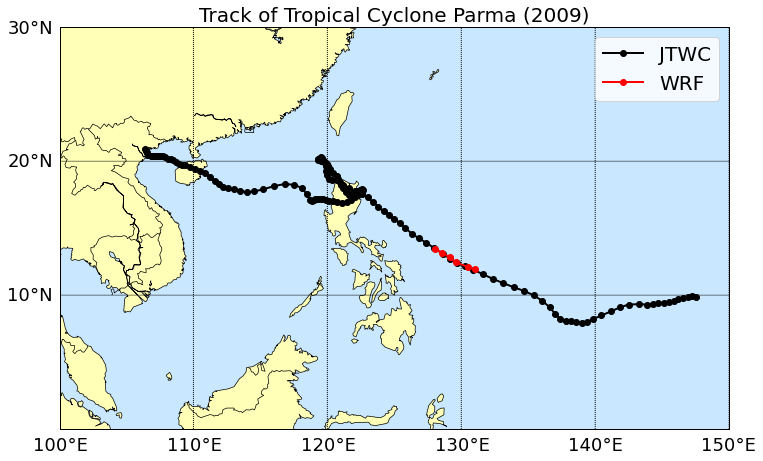

In [61]:
rwop = jtwc_filtered[(jtwc_filtered["NAME"] == "PARMA") & (jtwc_filtered["SEASON"] == 2009)]
rwp_track = jtwc_dat[(jtwc_dat["NAME"] == "PARMA") & (jtwc_dat["SEASON"] == 2009)]


plt.figure(figsize = (12,8))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=150,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 18)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 18)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
#poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
#plt.gca().add_patch(poly)

for name, group in rwp_track.groupby("SID"):
    lat = group.USA_LAT.values 
    lon = group.USA_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'ko-', linewidth = 2, label = "JTWC")
    
c_lon = [131.052, 130.501, 129.582, 129.123, 128.572, 128.02]
c_lat = [11.92, 12.1, 12.46, 12.82, 13.18, 13.44]

plt.plot(c_lon, c_lat, "ro-", linewidth = 2, label = "WRF")
    
# for name1, group1 in rwop.groupby("SID"):
#     lat = group1.USA_LAT.values 
#     lon = group1.USA_LON.values
#     x1,y1 = m(lon, lat)
#     plt.plot(x1,y1, 'ro', linewidth = 0.3)
    
#plt.axhline(y=16, color='r', linestyle='-')     
plt.title("Track of Tropical Cyclone Parma (2009)", fontsize = 20)
plt.legend(fontsize = 20, loc="upper right")
plt.show()

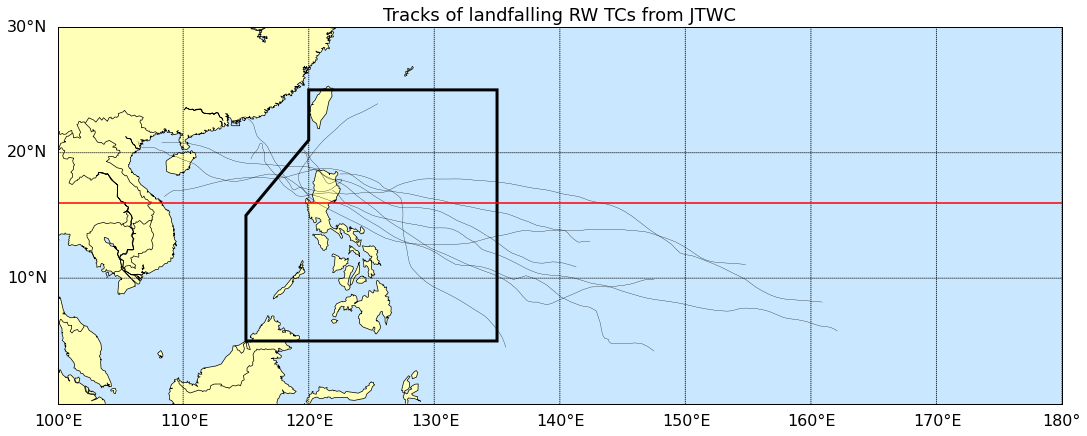

In [62]:
lan = luztc["SID"].unique().tolist()
land = jtwc_dat[jtwc_dat["SID"].isin(lan)]
rwp = jtwc_filtered[jtwc_filtered["SID"].isin(lan)]

land_ind = land[(land["USA_LON"] >= 100) & (land["USA_LON"] <= 180)].index
land_lon = land.loc[land_ind]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in land_lon.groupby("SID"):
    lat = group.USA_LAT.values 
    lon = group.USA_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.3)
    
plt.axhline(y=16, color='r', linestyle='-')     
plt.title("Tracks of landfalling RW TCs from JTWC", fontsize = 18)
plt.show()

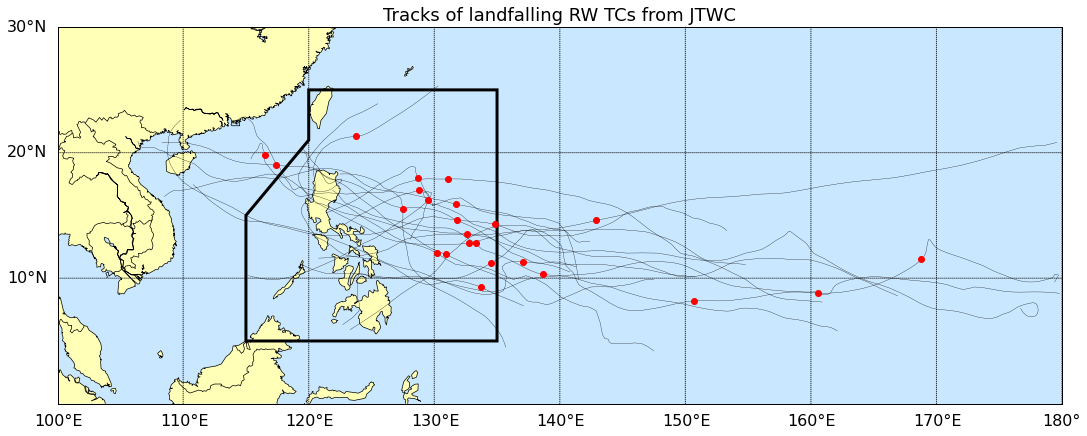

In [63]:
lan = tt2["SID"].unique().tolist()
land = jtwc_dat[jtwc_dat["SID"].isin(lan)]
rwp = jtwc_filtered[jtwc_filtered["SID"].isin(lan)]

land_ind = land[(land["USA_LON"] >= 100) & (land["USA_LON"] <= 180)].index
land_lon = land.loc[land_ind]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in land_lon.groupby("SID"):
    lat = group.USA_LAT.values 
    lon = group.USA_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.3)
    
for name1, group1 in rwp.groupby("SID"):
    lat = group1.USA_LAT.values 
    lon = group1.USA_LON.values
    x1,y1 = m(lon, lat)
    plt.plot(x1,y1, 'ro', linewidth = 0.3)
    
plt.title("Tracks of landfalling RW TCs from JTWC", fontsize = 18)
plt.show()

### Statistics

In [64]:
month_f = jtwc_data.groupby("SID").first().reset_index()
mon_tcfreq = month_f["SID"].unique().tolist()
month_freq =  month_f[month_f["SID"].isin(mon_tcfreq)]

rw_f = jtwc_filtered.groupby("SID").first().reset_index()
rw_tcfreq = rw_f["SID"].unique().tolist()
rw_freq = rw_f[rw_f["SID"].isin(rw_tcfreq)] 

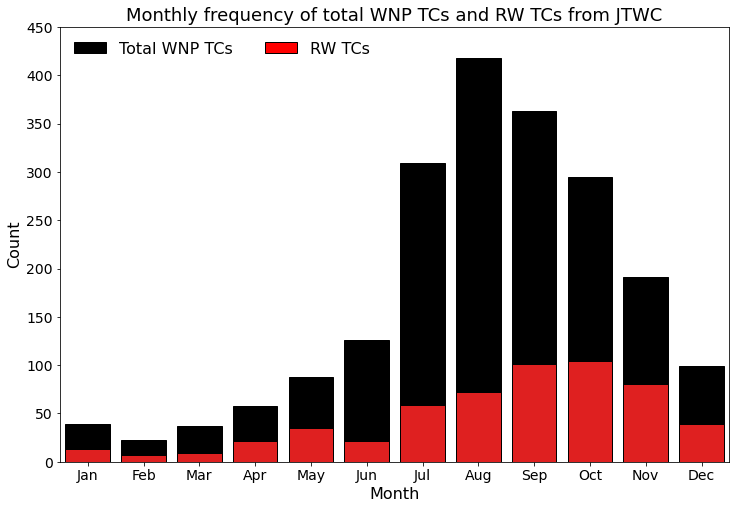

In [65]:
ncount = len(rw_freq)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax_tot = sns.countplot(x="month",data = month_freq, order = month_order, color ="black", edgecolor = "black")
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = rw_freq, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Total WNP TCs', 'RW TCs'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)

ax_tot.set_ylim(0,450)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency of total WNP TCs and RW TCs from JTWC",fontsize = 18)
plt.show()



In [66]:
tot_lan =  jtwc_data.groupby("SID").first().reset_index()
total =  landfall_tcs["SID"].unique().tolist()
total_lf =  tot_lan[tot_lan["SID"].isin(total)]

rw_lan = tt2.groupby("SID").first().reset_index()
rw_tot = tt2["SID"].unique().tolist()
rw_lf = rw_lan[rw_lan["SID"].isin(rw_tot)] 

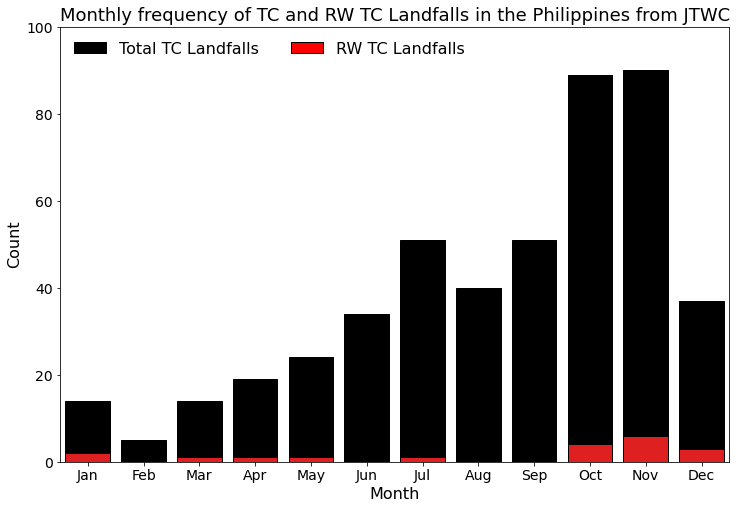

In [67]:
ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax_tot = sns.countplot(x="month",data = total_lf, order = month_order, color ="black", edgecolor = "black")
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = rw_lf, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Total TC Landfalls', 'RW TC Landfalls'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)


ax_tot.set_ylim(0,100)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency of TC and RW TC Landfalls in the Philippines from JTWC",fontsize = 18)
plt.show()



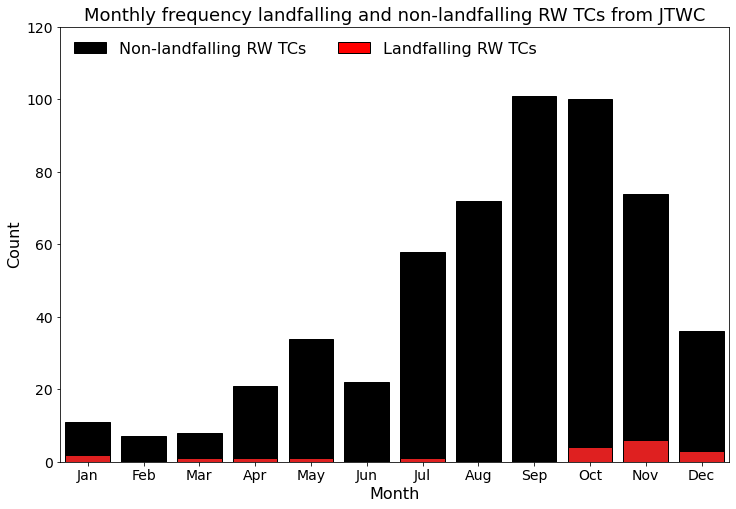

In [68]:
lf_ind = tt2["SID"].unique().tolist()
nonlandfall_rw = jtwc_filtered[~jtwc_filtered["SID"].isin(lf_ind)]
nonlandfall_rw.SID.nunique()
nonland_ind = nonlandfall_rw["SID"].unique().tolist()
nonlandfalling_rw = jtwc_lon[jtwc_lon["SID"].isin(nonland_ind)]
nonlandfall_rw1 = nonlandfall_rw.drop_duplicates(subset = ["SID"])
land_rwtcs1 = rw_lf


ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = nonlandfall_rw1, order = month_order, color ="black", edgecolor = "black")

ax_rwtc = sns.countplot(x="month",data = land_rwtcs1, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Non-landfalling RW TCs', 'Landfalling RW TCs'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)

plt.ylim(0,120)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency landfalling and non-landfalling RW TCs from JTWC",fontsize = 18)
plt.show()



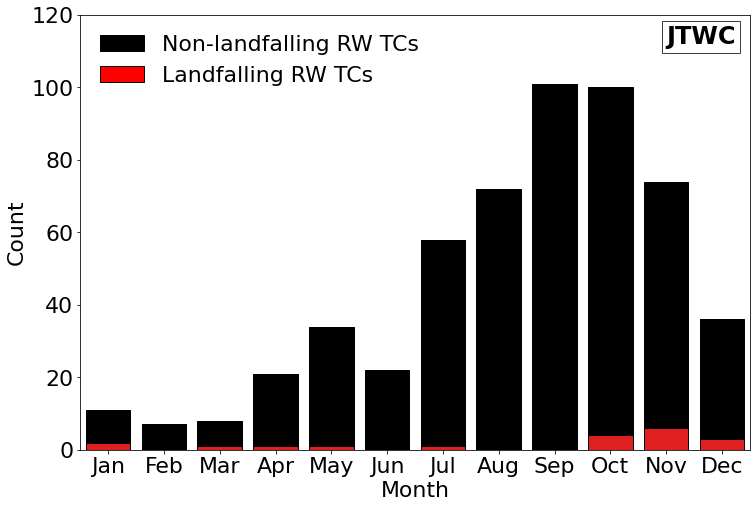

In [69]:
lf_ind = tt2["SID"].unique().tolist()
nonlandfall_rw = jtwc_filtered[~jtwc_filtered["SID"].isin(lf_ind)]
nonlandfall_rw.SID.nunique()
nonland_ind = nonlandfall_rw["SID"].unique().tolist()
nonlandfalling_rw = jtwc_lon[jtwc_lon["SID"].isin(nonland_ind)]
nonlandfall_rw1 = nonlandfall_rw.drop_duplicates(subset = ["SID"])
land_rwtcs1 = rw_lf


ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = nonlandfall_rw1, order = month_order, color ="black", edgecolor = "black")

ax_rwtc = sns.countplot(x="month",data = land_rwtcs1, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Non-landfalling RW TCs', 'Landfalling RW TCs'], loc= 2, ncol = 1, prop={'size':22})
l.draw_frame(False)

text3 = f"JTWC"
#text3 = f"$y={z3[0]:0.3f}\;x{z3[1]:+0.3f}$\n$p = {0.000:0.3f}$"
t3 = plt.text(10, 112, text3, fontsize = 24, fontweight = "bold")
t3.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

plt.ylim(0,120)
plt.ylabel("Count", fontsize = 22)
plt.xlabel("Month", fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
#plt.title("Monthly frequency landfalling and non-landfalling RW TCs from JTWC",fontsize = 18)
plt.show()



### TC trend

In [70]:
TC = jtwc_data.groupby("SID").first().reset_index()
tc_year = TC["SEASON"].value_counts().to_frame().reset_index()
tc_year = tc_year.sort_values(by = "index")
tc_year = tc_year.reset_index(drop=True)

counts = tc_year.SEASON.values
year = tc_year["index"].values

#----------------------------------

sat = TC[TC["SEASON"] >= 1978].index
sat_TC = TC.loc[sat]
tc_year1978 = sat_TC["SEASON"].value_counts().to_frame().reset_index()
tc_year1978 = tc_year1978.sort_values(by = "index")
tc_year1978 = tc_year1978.reset_index(drop=True)

year1978 = tc_year1978["index"].values
counts1978 = tc_year1978.SEASON.values

#----------------------------------

#number of RW TCs in WNP
land_TC = jtwc_data1.groupby("SID").first().reset_index()
landrwtc_year = land_TC["SEASON"].value_counts().to_frame().reset_index()
landrwtc_year = landrwtc_year.sort_values(by = "index")
landrwtc_year = landrwtc_year.reset_index(drop=True)

year_rw = landrwtc_year["index"].values
count_rw = landrwtc_year.SEASON.values

#----------------------------------

sat_rw = land_TC[land_TC["SEASON"] >= 1978].index
sat_rwtc = land_TC.loc[sat_rw]
satrw_1978 = sat_rwtc["SEASON"].value_counts().to_frame().reset_index()
satrw_1978 = satrw_1978.sort_values(by = "index")
satrw_1978 = satrw_1978.reset_index(drop=True)

year_rw1978 = satrw_1978["index"].values
count_rw1978 = satrw_1978.SEASON.values

#----------------------------------

model = smf.ols("year ~ counts", data = tc_year).fit()
model2 = smf.ols("year1978 ~ counts1978", data = tc_year1978).fit()
model3 = smf.ols("year_rw ~ count_rw", data = landrwtc_year).fit()
model4 = smf.ols("year_rw1978 ~ count_rw1978", data = satrw_1978).fit()

Text(0.5, 1.0, 'Frequency of TC and RW TC Genesis in the WNP from JTWC')

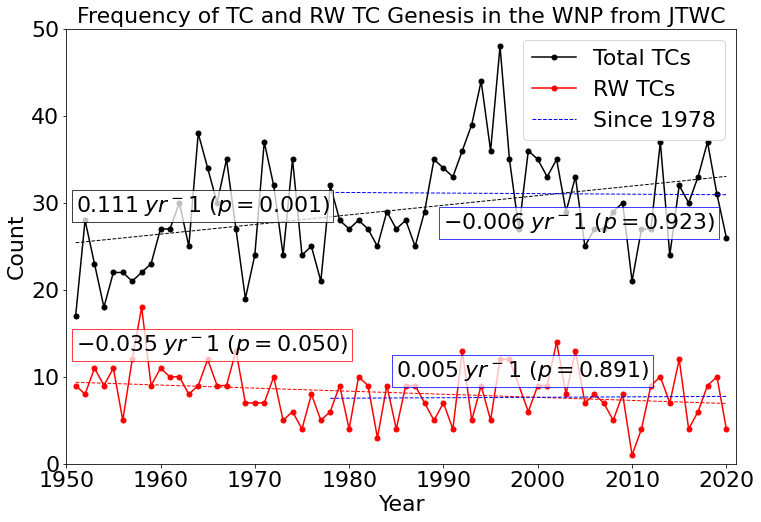

In [71]:
plt.figure(figsize = (12,8))
plt.plot(year,counts,"k.-", ms=10, mec="k", label = "Total TCs")
z = np.polyfit(year, counts, 1)
y_hat = np.poly1d(z)(year)

                      
plt.plot(year, y_hat, "k--", lw=1)
text1 = f"${z[0]:0.3f}\; yr^{-1}$ $(p = {round(model.pvalues[1], 3):0.3f})$"
t1 = plt.text(1951, 29, text1, fontsize = 22)
t1.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))
#plt.gca().text(0.05, 0.95, text1,transform=plt.gca().transAxes,
     #fontsize=10, verticalalignment='top')

z2 = np.polyfit(year1978, counts1978, 1)
y_hat2 = np.poly1d(z2)(year1978)
plt.plot(year1978, y_hat2, "b--", lw=1)
text2 = f"${z2[0]:0.3f}\; yr^{-1}$ $(p = {round(model2.pvalues[1], 3):0.3f})$"
#text2 = f"$y={z2[0]:0.3f}\;x{z2[1]:+0.3f}$\n$p = {0.066:0.3f}$"
t2 = plt.text(1990, 27, text2, fontsize = 22)
t2.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))

#######

plt.plot(year_rw, count_rw, "r.-", ms=10, mec="r", label = "RW TCs")
z3 = np.polyfit(year_rw, count_rw, 1)
y_hat3 = np.poly1d(z3)(year_rw)

plt.plot(year_rw, y_hat3, "r--", lw=1)
text3 = f"${z3[0]:0.3f}\; yr^{-1}$ $(p = {round(model3.pvalues[1], 3):0.3f})$"
#text3 = f"$y={z3[0]:0.3f}\;x{z3[1]:+0.3f}$\n$p = {0.000:0.3f}$"
t3 = plt.text(1951, 13, text3, fontsize = 22)
t3.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "red"))

z4 = np.polyfit(year_rw1978, count_rw1978, 1)
y_hat4 = np.poly1d(z4)(year_rw1978)
plt.plot(year_rw1978, y_hat4, "b--", lw=1, label = "Since 1978")
text4 = f"${z4[0]:0.3f}\; yr^{-1}$ $(p = {round(model4.pvalues[1], 3):0.3f})$"
#text4 = f"$y={z4[0]:0.3f}\;x{z4[1]:+0.3f}$\n$p = {0.103:0.3f}$"
t4 = plt.text(1985, 10, text4, fontsize = 22)
t4.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))

plt.legend(fontsize = 22)
plt.xlim(1950,2021)
plt.xlabel("Year", fontsize = 22)
plt.ylabel("Count", fontsize = 22)
plt.ylim(0, 50)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.title("Frequency of TC and RW TC Genesis in the WNP from JTWC", fontsize = 22)

In [72]:
landrwtc_year["ratio"] = (landrwtc_year["SEASON"]/tc_year.SEASON)*100
ratio = landrwtc_year.ratio.values
ratio_tc = landrwtc_year[["index", "ratio"]]

satrw_1978["ratio"] = (satrw_1978.SEASON/tc_year1978.SEASON)*100
ratio1978 = satrw_1978.ratio.values
satrw_1978ratio = satrw_1978[["index", "ratio"]]

modelr = smf.ols("year_rw ~ ratio", data = ratio_tc).fit()
modelr1978 = smf.ols("year_rw1978 ~ ratio1978", data = satrw_1978ratio).fit()

Text(0.5, 1.0, 'Ratio of RW TCs to Total WNP TCs from JTWC')

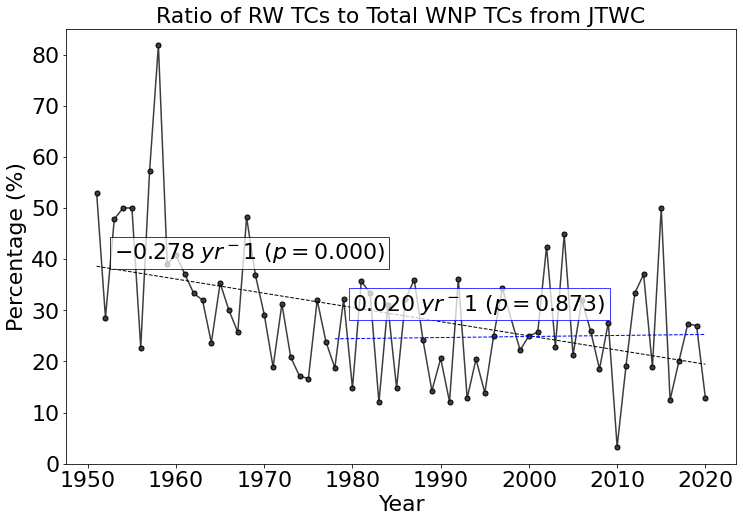

In [73]:
plt.figure(figsize = (12,8))
plt.plot(year_rw, ratio, color = "#3a3d42" ,linestyle = "-", marker= ".", ms=10, mec="k", label = "Total TCs")
zr = np.polyfit(year_rw, ratio, 1)
y_hatr = np.poly1d(zr)(year_rw)

                      
plt.plot(year_rw, y_hatr, "k--", lw=1)
textr = f"${zr[0]:0.3f}\; yr^{-1}$ $(p = {round(modelr.pvalues[1], 3):0.3f})$"
tr = plt.text(1953, 40, textr, fontsize = 22)
tr.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))


zr1978 = np.polyfit(year_rw1978, ratio1978, 1)
y_hatr1978 = np.poly1d(zr1978)(year_rw1978)
plt.plot(year_rw1978, y_hatr1978, "b--", lw=1)
textr1978 = f"${zr1978[0]:0.3f}\; yr^{-1}$ $(p = {round(modelr1978.pvalues[1], 3):0.3f})$"
tr1978 = plt.text(1980, 30, textr1978, fontsize = 22)
tr1978.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))
plt.xlabel("Year", fontsize = 22)
plt.ylabel("Percentage (%)", fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.ylim(0, 85)
plt.title("Ratio of RW TCs to Total WNP TCs from JTWC", fontsize = 22)

### Mean drop during landfall

In [74]:
par_ind = jtwc_data[(jtwc_data["DIST2LAND"] >=0) & (jtwc_data["USA_LON"] <= 130) & (jtwc_data["USA_LON"] >= 115) & (jtwc_data["USA_LAT"] >= 5) & (jtwc_data["USA_LAT"] <= 20)].index
#jtwc_data[(jtwc_data["DIST2LAND"] >=0) &(jtwc_data["DIST2LAND"] <= 25.4) & (jtwc_data["USA_LON"] < 130) & (jtwc_data["USA_LON"] > 115) & (jtwc_data["USA_LAT"]>5) & (jtwc_data["USA_LAT"] <20)].index
par_tcs = jtwc_data.loc[par_ind]
par_sid = par_tcs["SID"].unique().tolist()
partc = jtwc_data[jtwc_data["SID"].isin(par_sid)]

jtwcpar_ind = partc[partc["SEASON"] == 2015].index
jtwcpar = partc.loc[jtwcpar_ind]
print(jtwcpar.NAME.unique())

['MEKKHALA' 'BAVI' 'MAYSAK' 'NOUL' 'LINFA' 'NOT_NAMED' 'GONI' 'MUJIGAE'
 'KOPPU' 'MELOR']


In [75]:
par_tcs["percent_drop"] = (par_tcs["diff_6h"].abs()/par_tcs["USA_WIND"])*100
par_tcs["percent_drop_24"] = (par_tcs["diff_24h"].abs()/par_tcs["USA_WIND"])*100
par_tcs["wind_6h"] = par_tcs["USA_WIND"].shift(-1)
par_tcs[["NAME", "ISO_TIME", "DIST2LAND", "dist_6h","wind_6h","USA_WIND", "USA_LON", "USA_LAT"]]

,NAME,ISO_TIME,DIST2LAND,dist_6h,wind_6h,USA_WIND,USA_LON,USA_LAT
207,IRIS,1951-05-04 00:00:00,381,230.0,140.0,150.0,129.4,12.0
209,IRIS,1951-05-04 06:00:00,230,117.0,130.0,140.0,127.8,12.1
211,IRIS,1951-05-04 12:00:00,117,10.0,110.0,130.0,126.6,12.0
213,IRIS,1951-05-04 18:00:00,10,0.0,80.0,110.0,125.4,12.1
215,IRIS,1951-05-05 00:00:00,0,24.0,70.0,80.0,124.7,12.2
...,...,...,...,...,...,...,...,...
167239,KROVANH,2020-12-19 06:00:00,113,10.0,25.0,20.0,120.1,9.1
167241,KROVANH,2020-12-19 12:00:00,10,117.0,20.0,25.0,119.2,9.6
167243,KROVANH,2020-12-19 18:00:00,117,257.0,25.0,20.0,117.4,10.0
167245,KROVANH,2020-12-20 00:00:00,257,309.0,25.0,25.0,115.5,10.3


In [76]:
par_tcs.SID.nunique()

985

In [77]:
#obtain mean drop in wind speed during landfall

l_ind =  par_tcs[(par_tcs["dist_6h"] <= 25.4) & (par_tcs["dist_6h"] >= 0)  & (par_tcs["diff_6h"] <= 0)].index
landfall_tf = par_tcs.loc[l_ind]
#landfall_tf[["NAME", "SEASON","ISO_TIME","USA_LON", "USA_LAT", "DIST2LAND", "dist_24h", "diff_24h",]].head(60)

In [78]:
landfall_tf.SID.nunique()

433

In [79]:
mean = landfall_tf["diff_6h"].abs().mean() 
mean_per = landfall_tf["percent_drop"].mean()  
above_ind =landfall_tf[landfall_tf["diff_6h"].abs() > mean].index
above_mean = landfall_tf.loc[above_ind]
print(above_mean.SID.nunique())

abovep_ind =landfall_tf[landfall_tf["percent_drop"] > mean_per].index
abovep_mean = landfall_tf.loc[abovep_ind]
print(abovep_mean.SID.nunique())
#above_mean[["NAME", "SEASON","ISO_TIME","USA_LON", "USA_LAT", "DIST2LAND", "dist_24h", "diff_24h", "USA_WIND"]].head(60)

198
281


In [80]:
print(mean)
print(mean_per)

5.928697183098592
8.258835998555517


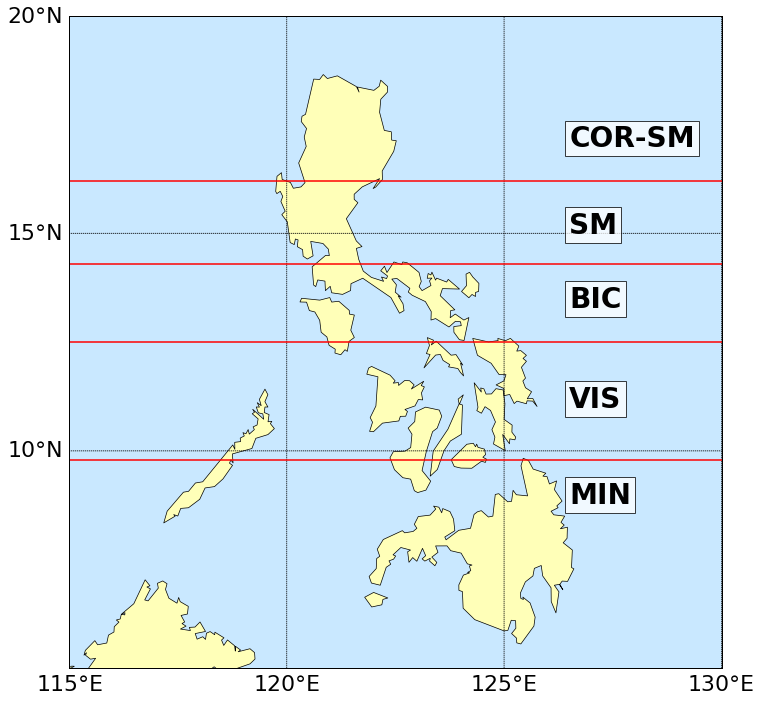

In [81]:
plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=5,urcrnrlat=20, llcrnrlon=115,urcrnrlon=130,lat_ts = 10, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,5),labels=[1,0,0,0], fontsize = 22)
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1], fontsize = 22)

plt.axhline(y=12.5, color='r', linestyle='-')
plt.axhline(y=16.2, color='r', linestyle='-')
plt.axhline(y=14.3, color='r', linestyle='-')
plt.axhline(y=9.8, color='r', linestyle='-')

r1 = r"COR-SM"
t1 = plt.text(126.5, 17, r1, fontsize = 28, fontweight ="bold")
t1.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

r2 = r"SM"
t2 = plt.text(126.5, 15, r2, fontsize = 28, fontweight ="bold")
t2.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

r3 = r"BIC"
t3 = plt.text(126.5, 13.3, r3, fontsize = 28, fontweight ="bold")
t3.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

r4 = r"VIS"
t4 = plt.text(126.5, 11, r4, fontsize = 28, fontweight ="bold")
t4.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

r5 = r"MIN"
t5 = plt.text(126.5, 8.8, r5, fontsize = 28, fontweight ="bold")
t5.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

In [82]:
landfall_tff =landfall_tf.groupby("SID").first().reset_index()
landfall_tff[["NAME", "ISO_TIME", "DIST2LAND", "dist_6h", "dist_24h", "USA_WIND", "diff_6h", "diff_24h", "percent_drop"]]

,NAME,ISO_TIME,DIST2LAND,dist_6h,dist_24h,USA_WIND,diff_6h,diff_24h,percent_drop
0,IRIS,1951-05-04 12:00:00,117,10.0,24.0,130.0,-20.0,-65.0,15.384615
1,LOUISE,1951-07-29 18:00:00,81,0.0,39.0,110.0,-10.0,-30.0,9.090909
2,WANDA,1951-11-20 06:00:00,66,0.0,74.0,90.0,-0.0,-5.0,0.000000
3,AMY,1951-12-09 00:00:00,111,10.0,10.0,100.0,-5.0,-15.0,5.000000
4,EMMA,1952-07-02 00:00:00,69,15.0,54.0,110.0,-20.0,-60.0,18.181818
...,...,...,...,...,...,...,...,...,...
428,SAUDEL,2020-10-20 06:00:00,122,11.0,171.0,45.0,-0.0,-0.0,0.000000
429,GONI,2020-10-31 18:00:00,64,0.0,70.0,170.0,-40.0,-120.0,23.529412
430,ETAU,2020-11-07 18:00:00,33,0.0,499.0,20.0,-0.0,10.0,0.000000
431,VAMCO,2020-11-11 12:00:00,55,0.0,272.0,100.0,-5.0,-25.0,5.000000


In [83]:
r1 =  landfall_tff[(landfall_tff["USA_LON"] >= 115) & (landfall_tff["USA_LON"] <= 130)
            & (landfall_tff["USA_LAT"] >= 16.2) &  (landfall_tff["USA_LAT"] <= 20) ].index
r1_tc = landfall_tff.loc[r1]
print(r1_tc.SID.nunique())

avew_r1 = r1_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r1)

avei_r1 = r1_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r1)

avep_r1 = r1_tc["percent_drop"].mean() 
print("percent_drop =", avep_r1)

107
landfall_intensity = 66.96261682242991
intensity_drop = 9.439252336448599
percent_drop = 11.142479350399057


In [84]:
r2 =  landfall_tff[(landfall_tff["USA_LON"] >= 115) & (landfall_tff["USA_LON"] <= 130)
            & (landfall_tff["USA_LAT"] >= 14.3) &  (landfall_tff["USA_LAT"] < 16.2) ].index
r2_tc = landfall_tff.loc[r2]
print(r2_tc.SID.nunique())

avew_r2 = r2_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r2)

avei_r2 = r2_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r2)

avep_r2 = r2_tc["percent_drop"].mean() 
print("percent_drop =", avep_r2)

85
landfall_intensity = 56.294117647058826
intensity_drop = 9.823529411764707
percent_drop = 11.96903167519076


In [85]:
r3 =  landfall_tff[(landfall_tff["USA_LON"] >= 115) & (landfall_tff["USA_LON"] <= 130)
            & (landfall_tff["USA_LAT"] >= 12.5) &  (landfall_tff["USA_LAT"] < 14.3) ].index
r3_tc = landfall_tff.loc[r3]
print(r3_tc.SID.nunique())

avew_r3 = r3_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r3)

avei_r3 = r3_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r3)

avep_r3 = r3_tc["percent_drop"].mean() 
print("percent_drop =", avep_r3)

71
landfall_intensity = 66.12676056338029
intensity_drop = 4.507042253521127
percent_drop = 5.170452594903038


In [86]:
r4 =  landfall_tff[(landfall_tff["USA_LON"] >= 115) & (landfall_tff["USA_LON"] <= 130)
            & (landfall_tff["USA_LAT"] >= 9.8) &  (landfall_tff["USA_LAT"] < 12.5) ].index
r4_tc = landfall_tff.loc[r4]
print(r4_tc.SID.nunique())

avew_r4 = r4_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r4)

avei_r4 = r4_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r4)

avep_r4 = r4_tc["percent_drop"].mean() 
print("percent_drop =", avep_r4)

115
landfall_intensity = 49.608695652173914
intensity_drop = 3.0434782608695654
percent_drop = 4.478935917285627


In [87]:
r5 =  landfall_tff[(landfall_tff["USA_LON"] >= 115) & (landfall_tff["USA_LON"] <= 130)
            & (landfall_tff["USA_LAT"] >= 0) &  (landfall_tff["USA_LAT"] < 9.8) ].index
r5_tc = landfall_tff.loc[r5]
print(r5_tc.SID.nunique())

avew_r5 = r5_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r5)

avei_r5 = r5_tc["diff_24h"].abs().mean() 
print("intensity_drop =",avei_r5)

avep_r5 = r5_tc["percent_drop"].mean() 
print("percent_drop =", avep_r5)

55
landfall_intensity = 39.09090909090909
intensity_drop = 14.7
percent_drop = 6.3786582104763925


In [88]:
jtwc_filtered["diff_24h"].abs().mean()

30.70878274268105

In [89]:
jtwc_filtered["percent_drop"] = (jtwc_filtered["diff_24h"].abs()/jtwc_filtered["USA_WIND"])*100
jtwc_filtered["percent_drop"].abs().mean()

31.616104697459743

In [90]:
indx2 = tt2["SID"].unique().tolist()
drop2 = jtwc_filtered[jtwc_filtered["SID"].isin(indx2)] #TC data of all RW TCs 
indz = drop2[(drop2["USA_LON"] >= 116.5)].index
drop3 = drop2.loc[indz]
print(drop2["diff_24h"].abs().mean())
print(drop3["diff_24h"].abs().mean())

30.833333333333332
30.833333333333332


In [91]:
drop2["percent_drop"].abs().mean()

34.60853025716565

In [92]:
jtwc_filtered.SID.nunique()

563

In [93]:
drop2.SID.nunique()

19